In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=5, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.4
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 读取数据

In [2]:
train_dir = "./10monkeys/training/training/"
valid_dir = "./10monkeys/validation/validation/"
label_file = "./10monkeys/monkey_labels.txt"

In [3]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

## 2. 数据增强

In [4]:
height = 224
width = 224
channels = 3
batch_size = 24
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size= batch_size,
    seed=7,
    shuffle=True,
    class_mode="categorical")

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(height, width),
    batch_size=batch_size,
    seed=7,
    shuffle=False,
    class_mode="categorical")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1100 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1100 272


In [5]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y[:5])

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## 3. 构建迁移学习模型（保持resnet已训练参数不变，训练全连接层参数）

In [6]:
resnet = keras.applications.ResNet50(
    include_top=False,    # 除去resnet最后一层，分类数与原网络不同
    pooling="avg",
    weights="imagenet")   # 使用已经训练好的参数

print(type(resnet))
print(isinstance(resnet, keras.layers.Layer))  # 既是层对象
print(isinstance(resnet, keras.models.Model))  # 也是模型对象

<class 'tensorflow.python.keras.engine.training.Model'>
True
True


In [7]:
resnet50_fine_tune = keras.models.Sequential()
resnet50_fine_tune.add(keras.applications.ResNet50(
    include_top=False,  
    pooling="avg",
    weights="imagenet"))   # 整个resnet50模型作为新模型的第一层
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation="softmax"))
resnet50_fine_tune.layers[0].trainable=False  # 不将resnet层参数一起再训练

resnet50_fine_tune.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
resnet50_fine_tune.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


## 4. 训练模型

In [8]:
epochs = 2
history = resnet50_fine_tune.fit_generator(train_generator,
                              steps_per_epoch=train_num // batch_size,
                              epochs= epochs,
                              validation_data=valid_generator,
                              validation_steps=valid_num // batch_size)

Epoch 1/2
45/45 [==============================] - 554s 12s/step - loss: 1.6344 - accuracy: 0.4823 - val_loss: 0.7182 - val_accuracy: 0.8068
Epoch 2/2
45/45 [==============================] - 542s 12s/step - loss: 0.7264 - accuracy: 0.8401 - val_loss: 0.3982 - val_accuracy: 0.9091


In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

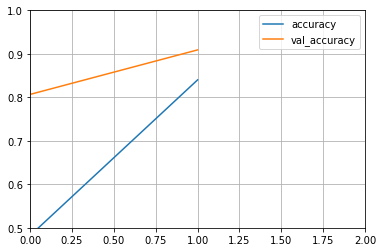

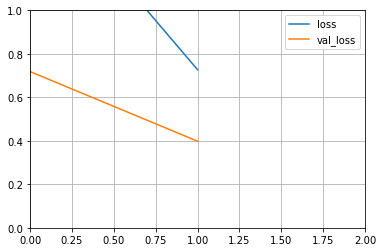

In [10]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data["val_"+label] = history.history["val_"+label]
    pd.DataFrame(data).plot(figsize=(6, 4))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, "accuracy", epochs, 0.5, 1)
plot_learning_curves(history, "loss", epochs, 0.,1.)

## 5. 构建迁移学习模型（再次训练resnet最后几层已训练好的参数和全连接层参数）

In [11]:
resnet50 = keras.applications.ResNet50(include_top=False,
                                       pooling="avg",
                                       weights="imagenet")
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
for layer in resnet50.layers[0:-5]:
    layer.trainable=False
    
resnet50_new = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes, activation="softmax")
])

resnet50_new.compile(loss="categorical_crossentropy",
                     optimizer="sgd", 
                     metrics=["accuracy"])
resnet50_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 1,075,210
Non-trainable params: 22,532,992
_________________________________________________________________


## 6. 训练模型

In [ ]:
epochs = 10
history = resnet50_fine_tune.fit_generator(
    train_generator,
    steps_per_epoch=train_num // batch_size,
    epochs= epochs,
    validation_data=valid_generator,
    validation_steps=valid_num // batch_size)

Epoch 1/10
45/45 [==============================] - 620s 14s/step - loss: 0.4760 - accuracy: 0.9052 - val_loss: 0.2902 - val_accuracy: 0.9205
Epoch 2/10
45/45 [==============================] - 617s 14s/step - loss: 0.3661 - accuracy: 0.9349 - val_loss: 0.2423 - val_accuracy: 0.9318
Epoch 3/10
45/45 [==============================] - 575s 13s/step - loss: 0.3124 - accuracy: 0.9433 - val_loss: 0.2784 - val_accuracy: 0.9205
Epoch 4/10
45/45 [==============================] - 580s 13s/step - loss: 0.2553 - accuracy: 0.9535 - val_loss: 0.2508 - val_accuracy: 0.9280
Epoch 5/10
45/45 [==============================] - 624s 14s/step - loss: 0.2219 - accuracy: 0.9554 - val_loss: 0.1909 - val_accuracy: 0.9394
Epoch 6/10
45/45 [==============================] - 628s 14s/step - loss: 0.2299 - accuracy: 0.9472 - val_loss: 0.2086 - val_accuracy: 0.9356
Epoch 7/10
45/45 [==============================] - 583s 13s/step - loss: 0.1845 - accuracy: 0.9674 - val_loss: 0.1837 - val_accuracy: 0.9394
Epoch 

1. 参数更多，需要更多的迭代；
2. resnet50原有参数已经是比较好的状态，如果再跟新的全连接层一起训练，刚开始设置了较大的学习率，可能会打破原有的好的参数状态从而重新学习；